In [4]:
include("../taxi_model.jl")

train_decoder (generic function with 1 method)

# Helper Functions

In [2]:
include("/home/smkatz/Documents/Util/support_code.jl");

In [5]:
using PGFPlots
using Distributions
using NearestNeighbors

function plot_results(npn, im; χ_prior = [0.0, 0.0], n_prior = 1.0, simple = false,
    ymin = -1.1, ymax = 1.1)
    # Prior
    μ₀_prior, σ₀²_prior = to_normal(χ_prior, n_prior, npn.σ²)
    println(σ₀²_prior)
    f_prior(x, y) = pdf(MvNormal(μ₀_prior, σ₀²_prior * I), [x, y])

    # Posterior
    if simple
        χ_post, n_post = get_posterior_simple(npn, im, χ_prior = χ_prior, n_prior = n_prior)
    else
        χ_post, n_post = get_posterior(npn, im, χ_prior = χ_prior, n_prior = n_prior)
    end
    μ₀, σ₀² = to_normal(χ_post, n_post, npn.σ²)
    println(σ₀²)
    f(x, y) = pdf(MvNormal(μ₀, σ₀² * I), [x, y])

    if simple
        χ_post_rand, n_post_rand = get_posterior_simple(npn, rand(128), χ_prior = χ_prior, n_prior = n_prior)
    else
        χ_post_rand, n_post_rand = get_posterior(npn, rand(128), χ_prior = χ_prior, n_prior = n_prior)
    end
    μ₀_rand, σ₀²_rand = to_normal(χ_post_rand, n_post_rand, npn.σ²)
    println(σ₀²_rand)
    f_rand(x, y) = pdf(MvNormal(μ₀_rand, σ₀²_rand * I), [x, y])

    ax1 = Axis(Plots.Image(f_prior, (ymin, ymax), (ymin, ymax), colorbar = false, colormap = pasteljet))
    ax1.xlabel = "crosstrack error"
    ax1.ylabel = "heading error"
    ax1.title = "Prior"
    ax1.height = "5.5cm"
    ax1.width = "5.5cm"
    # ax1.ymin = 0.0

    ax2 = Axis(Plots.Image(f, (ymin, ymax), (ymin, ymax), colorbar = false, colormap = pasteljet))
    ax2.xlabel = "crosstrack error"
    ax2.ylabel = "heading error"
    ax2.title = "Posterior Training Image"
    ax2.height = "5.5cm"
    ax2.width = "5.5cm"
    # ax2.ymin = 0.0

    ax3 = Axis(Plots.Image(f_rand, (ymin, ymax), (ymin, ymax), colorbar = false, colormap = pasteljet))
    ax3.xlabel = "crosstrack error"
    ax3.ylabel = "heading error"
    ax3.title = "Posterior Random Noise"
    ax3.height = "5.5cm"
    ax3.width = "5.5cm"
    # ax3.ymin = 0.0

    g = GroupPlot(3, 1, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
    push!(g, ax1)
    push!(g, ax2)
    push!(g, ax3)

    return g
end

function get_latent_distances(enc, Xin, Xout)
    # Compute latent representations
    Zin = enc(Xin)
    Zout = enc(Xout)

    # Create tree for nearest neighbors
    kdtree = KDTree(Zin)

    _, dists_in = knn(kdtree, Zin, 2)
    dists_in = [dists_in[i][1] for i = 1:length(dists_in)]
    _, dists_out = knn(kdtree, Zout, 1)
    dists_out = [dists_out[i][1] for i = 1:length(dists_out)]

    return dists_in, dists_out
end

get_latent_distances (generic function with 1 method)

In [6]:
Xf, yf = get_taxi_data([1,2]);

In [7]:
Xrand = rand(128, 10000)
Xc, yc = get_taxi_data([1,2], fn = "/scratch/smkatz/NeuralFilter/downsampled_crossing_data.h5", flipped = false);

In [8]:
X, y = get_taxi_data([1,2], fn = "/scratch/smkatz/NASA_ULI/data/morning_downsampled/morning_train_downsampled.h5", flipped = false);

In [9]:
Xa, ya = get_taxi_data([1,2], fn = "/scratch/smkatz/NASA_ULI/data/afternoon_downsampled/afternoon_train_downsampled.h5", flipped = false);

# Training as Autoencoder

In [10]:
npn = natPN_nonlinear_2d(h = 16, σ² = 0.01, entropy_reg = 1e-3);

In [85]:
nepoch = 250
lr = 5e-3
batchsize = 128

train_reconstruction(npn.encoder |> gpu, X |> gpu; device = gpu, nepoch = nepoch, lr = lr, batchsize = batchsize);

l = 0.24609728f0


┌ Info: Epoch 1
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.003696934f0


┌ Info: Epoch 2
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.003378737f0


┌ Info: Epoch 3
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0029575024f0


┌ Info: Epoch 4
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0026829818f0


┌ Info: Epoch 5
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0024940947f0


┌ Info: Epoch 6
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.002329172f0


┌ Info: Epoch 7
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0023382837f0


┌ Info: Epoch 8
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0021650973f0


┌ Info: Epoch 9
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.002016719f0


┌ Info: Epoch 10
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0019313548f0


┌ Info: Epoch 11
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0018512239f0


┌ Info: Epoch 12
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001785368f0


┌ Info: Epoch 13
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0017736407f0


┌ Info: Epoch 14
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0017625947f0


┌ Info: Epoch 15
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0016593112f0


┌ Info: Epoch 16
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0016628287f0


┌ Info: Epoch 17
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0016886963f0


┌ Info: Epoch 18
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0015634546f0


┌ Info: Epoch 19
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0015987775f0


┌ Info: Epoch 20
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0015689501f0


┌ Info: Epoch 21
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0014854944f0


┌ Info: Epoch 22
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0015122471f0


┌ Info: Epoch 23
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 24
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0014762392f0
l = 0.001486393f0


┌ Info: Epoch 25
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013836332f0


┌ Info: Epoch 26
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0014329795f0


┌ Info: Epoch 27
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013818953f0


┌ Info: Epoch 28
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013568084f0


┌ Info: Epoch 29
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013603391f0


┌ Info: Epoch 30
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013503121f0


┌ Info: Epoch 31
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013530882f0


┌ Info: Epoch 32
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013206229f0


┌ Info: Epoch 33
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013214219f0


┌ Info: Epoch 34
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013247674f0


┌ Info: Epoch 35
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013263245f0


┌ Info: Epoch 36
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013084138f0


┌ Info: Epoch 37
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012888267f0


┌ Info: Epoch 38
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012835655f0


┌ Info: Epoch 39
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012981453f0


┌ Info: Epoch 40
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001284607f0


┌ Info: Epoch 41
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012678668f0


┌ Info: Epoch 42
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.00130582f0


┌ Info: Epoch 43
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012552765f0


┌ Info: Epoch 44
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012886316f0


┌ Info: Epoch 45
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0013100838f0


┌ Info: Epoch 46
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012722192f0


┌ Info: Epoch 47
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012580338f0


┌ Info: Epoch 48
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012411285f0


┌ Info: Epoch 49
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012445902f0


┌ Info: Epoch 50
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012649349f0


┌ Info: Epoch 51
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012239721f0


┌ Info: Epoch 52
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001246169f0


┌ Info: Epoch 53
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012305877f0


┌ Info: Epoch 54
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012295336f0


┌ Info: Epoch 55
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012600808f0


┌ Info: Epoch 56
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012374312f0


┌ Info: Epoch 57
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012171308f0


┌ Info: Epoch 58
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012195942f0


┌ Info: Epoch 59
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012015295f0


┌ Info: Epoch 60
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012060285f0


┌ Info: Epoch 61
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012034073f0


┌ Info: Epoch 62
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012038007f0


┌ Info: Epoch 63
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012117063f0


┌ Info: Epoch 64
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012138266f0


┌ Info: Epoch 65
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012243998f0


┌ Info: Epoch 66
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011880825f0


┌ Info: Epoch 67
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011942564f0


┌ Info: Epoch 68
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012173753f0


┌ Info: Epoch 69
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001233525f0


┌ Info: Epoch 70
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011960736f0


┌ Info: Epoch 71
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011969316f0


┌ Info: Epoch 72
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011924742f0


┌ Info: Epoch 73
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012047113f0


┌ Info: Epoch 74
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012103368f0


┌ Info: Epoch 75
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011831291f0


┌ Info: Epoch 76
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011892765f0


┌ Info: Epoch 77
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011822885f0


┌ Info: Epoch 78
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012008422f0


┌ Info: Epoch 79
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011699386f0


┌ Info: Epoch 80
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012017726f0


┌ Info: Epoch 81
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001181632f0


┌ Info: Epoch 82
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011861454f0


┌ Info: Epoch 83
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011790899f0


┌ Info: Epoch 84
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011822924f0


┌ Info: Epoch 85
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001200998f0


┌ Info: Epoch 86
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011914776f0


┌ Info: Epoch 87
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001205703f0


┌ Info: Epoch 88
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011947782f0


┌ Info: Epoch 89
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011660119f0


┌ Info: Epoch 90
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012119854f0


┌ Info: Epoch 91
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012061483f0


┌ Info: Epoch 92
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011512339f0


┌ Info: Epoch 93
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011661843f0


┌ Info: Epoch 94
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011670204f0


┌ Info: Epoch 95
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011714936f0


┌ Info: Epoch 96
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011751545f0


┌ Info: Epoch 97
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012043711f0


┌ Info: Epoch 98
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011820693f0


┌ Info: Epoch 99
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011475954f0


┌ Info: Epoch 100
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001169696f0


┌ Info: Epoch 101
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011569345f0


┌ Info: Epoch 102
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011682734f0


┌ Info: Epoch 103
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011564806f0


┌ Info: Epoch 104
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011478219f0


┌ Info: Epoch 105
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011519258f0


┌ Info: Epoch 106
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011644631f0


┌ Info: Epoch 107
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011456461f0


┌ Info: Epoch 108
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0012438811f0


┌ Info: Epoch 109
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011405364f0


┌ Info: Epoch 110
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011571916f0


┌ Info: Epoch 111
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011299833f0


┌ Info: Epoch 112
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011776186f0


┌ Info: Epoch 113
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011654344f0


┌ Info: Epoch 114
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011624015f0


┌ Info: Epoch 115
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011901534f0


┌ Info: Epoch 116
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011425967f0


┌ Info: Epoch 117
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011384732f0


┌ Info: Epoch 118
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011611193f0


┌ Info: Epoch 119
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011761663f0


┌ Info: Epoch 120
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011478254f0


┌ Info: Epoch 121
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 122
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011621354f0
l = 0.0011443906f0


┌ Info: Epoch 123
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011535523f0


┌ Info: Epoch 124
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011396997f0


┌ Info: Epoch 125
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011411939f0


┌ Info: Epoch 126
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011365381f0


┌ Info: Epoch 127
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011731166f0


┌ Info: Epoch 128
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011492993f0


┌ Info: Epoch 129
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011273888f0


┌ Info: Epoch 130
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011382648f0


┌ Info: Epoch 131
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011519578f0


┌ Info: Epoch 132
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011236761f0


┌ Info: Epoch 133
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 134
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011312931f0
l = 0.0011435639f0


┌ Info: Epoch 135
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011395077f0


┌ Info: Epoch 136
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011165454f0


┌ Info: Epoch 137
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011378808f0


┌ Info: Epoch 138
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001119659f0


┌ Info: Epoch 139
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011403514f0


┌ Info: Epoch 140
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011418964f0


┌ Info: Epoch 141
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011544859f0


┌ Info: Epoch 142
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011484496f0


┌ Info: Epoch 143
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 144
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011441156f0
l = 0.0011160371f0


┌ Info: Epoch 145
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011356594f0


┌ Info: Epoch 146
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011359027f0


┌ Info: Epoch 147
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011185147f0


┌ Info: Epoch 148
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011365078f0


┌ Info: Epoch 149
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011419185f0


┌ Info: Epoch 150
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.00111631f0


┌ Info: Epoch 151
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011180991f0


┌ Info: Epoch 152
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011604116f0


┌ Info: Epoch 153
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011449561f0


┌ Info: Epoch 154
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011174984f0


┌ Info: Epoch 155
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011185615f0


┌ Info: Epoch 156
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011154944f0


┌ Info: Epoch 157
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011258698f0


┌ Info: Epoch 158
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001119002f0


┌ Info: Epoch 159
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011301249f0


┌ Info: Epoch 160
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001108424f0


┌ Info: Epoch 161
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011151663f0


┌ Info: Epoch 162
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011184209f0


┌ Info: Epoch 163
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001098691f0


┌ Info: Epoch 164
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011089293f0


┌ Info: Epoch 165
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001108821f0


┌ Info: Epoch 166
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011138144f0


┌ Info: Epoch 167
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011203456f0


┌ Info: Epoch 168
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011067097f0


┌ Info: Epoch 169
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 170
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011210559f0
l = 0.0011160902f0


┌ Info: Epoch 171
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011111926f0


┌ Info: Epoch 172
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011013713f0


┌ Info: Epoch 173
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011379423f0


┌ Info: Epoch 174
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011187766f0


┌ Info: Epoch 175
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 176
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010834855f0
l = 0.0011299448f0


┌ Info: Epoch 177
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001105959f0


┌ Info: Epoch 178
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 179
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011143564f0
l = 0.0011134654f0


┌ Info: Epoch 180
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010997579f0


┌ Info: Epoch 181
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001117702f0


┌ Info: Epoch 182
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011179995f0


┌ Info: Epoch 183
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011043706f0


┌ Info: Epoch 184
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001129349f0


┌ Info: Epoch 185
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011051199f0


┌ Info: Epoch 186
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001132366f0


┌ Info: Epoch 187
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011225089f0


┌ Info: Epoch 188
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011032289f0


┌ Info: Epoch 189
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011038099f0


┌ Info: Epoch 190
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001104094f0


┌ Info: Epoch 191
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010907892f0


┌ Info: Epoch 192
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011190198f0


┌ Info: Epoch 193
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010981543f0


┌ Info: Epoch 194
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011146944f0


┌ Info: Epoch 195
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011101465f0


┌ Info: Epoch 196
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011316467f0


┌ Info: Epoch 197
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011026694f0


┌ Info: Epoch 198
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010935452f0


┌ Info: Epoch 199
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010985854f0


┌ Info: Epoch 200
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011133178f0


┌ Info: Epoch 201
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001120762f0


┌ Info: Epoch 202
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011063325f0


┌ Info: Epoch 203
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011046105f0


┌ Info: Epoch 204
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011178725f0


┌ Info: Epoch 205
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011027622f0


┌ Info: Epoch 206
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011068657f0


┌ Info: Epoch 207
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010945806f0


┌ Info: Epoch 208
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011013555f0


┌ Info: Epoch 209
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011157205f0


┌ Info: Epoch 210
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010976306f0


┌ Info: Epoch 211
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011169564f0


┌ Info: Epoch 212
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011110889f0


┌ Info: Epoch 213
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011000219f0


┌ Info: Epoch 214
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010975525f0


┌ Info: Epoch 215
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011053034f0


┌ Info: Epoch 216
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001094498f0


┌ Info: Epoch 217
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010979832f0


┌ Info: Epoch 218
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010925729f0


┌ Info: Epoch 219
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010860335f0


┌ Info: Epoch 220
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011110515f0


┌ Info: Epoch 221
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011266838f0


┌ Info: Epoch 222
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011253011f0


┌ Info: Epoch 223
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011251856f0


┌ Info: Epoch 224
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011055998f0


┌ Info: Epoch 225
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011229647f0


┌ Info: Epoch 226
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010996489f0


┌ Info: Epoch 227
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 228
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011200485f0
l = 0.001088304f0


┌ Info: Epoch 229
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001093345f0


┌ Info: Epoch 230
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010892937f0


┌ Info: Epoch 231
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001095577f0


┌ Info: Epoch 232
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011170357f0


┌ Info: Epoch 233
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010824887f0


┌ Info: Epoch 234
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010863589f0


┌ Info: Epoch 235
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011149264f0


┌ Info: Epoch 236
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010929839f0


┌ Info: Epoch 237
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011230718f0


┌ Info: Epoch 238
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011057939f0


┌ Info: Epoch 239
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011063188f0


┌ Info: Epoch 240
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011023793f0


┌ Info: Epoch 241
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010787228f0


┌ Info: Epoch 242
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010795482f0


┌ Info: Epoch 243
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010881299f0


┌ Info: Epoch 244
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010945052f0


┌ Info: Epoch 245
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010865801f0


┌ Info: Epoch 246
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011022866f0


┌ Info: Epoch 247
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0011052468f0


┌ Info: Epoch 248
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.001094577f0


┌ Info: Epoch 249
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0010936076f0


┌ Info: Epoch 250
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


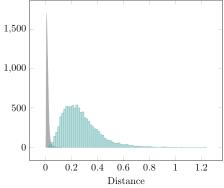

In [86]:
dists_in, dists_out = get_latent_distances(npn.encoder, X, Xrand)
ax = Axis()
push!(ax, Plots.Histogram(dists_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(dists_out, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Distance"
ax

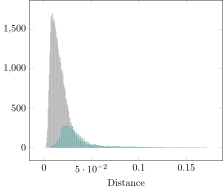

In [87]:
dists_in, dists_out = get_latent_distances(npn.encoder, X, Xc[:, 1801:end])
ax = Axis()
push!(ax, Plots.Histogram(dists_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(dists_out, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Distance"
ax

# Train Flow

In [88]:
npn.encoder |> cpu
z_in = npn.encoder(X);

In [89]:
nepoch = 50
lr = 1e-3
batchsize = 128

train_flow(npn.flow, z_in, y, nepoch, lr, batchsize);

┌ Info: Epoch 1
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 21.082711604786887


┌ Info: Epoch 2
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 4.684901399329296
l = -15.1956503529887


┌ Info: Epoch 3
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -26.363428122560354


┌ Info: Epoch 4
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -34.136863762342074


┌ Info: Epoch 5
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -36.44143169815053


┌ Info: Epoch 6
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -37.80604081746014


┌ Info: Epoch 7
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -38.6090466511734


┌ Info: Epoch 8
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -39.144172454791764


┌ Info: Epoch 9
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -39.507867969790105


┌ Info: Epoch 10
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -39.75110194373594


┌ Info: Epoch 11
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -39.97474503643877


┌ Info: Epoch 12
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.08397446865562


┌ Info: Epoch 13
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 14
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.22730803020612
l = -40.309886058166626


┌ Info: Epoch 15
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.39415363749567


┌ Info: Epoch 16
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.51168377220324


┌ Info: Epoch 17
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.562418099329264


┌ Info: Epoch 18
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.634816058948736


┌ Info: Epoch 19
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.673500190124045


┌ Info: Epoch 20
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.746942955811306


┌ Info: Epoch 21
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.79961757298263


┌ Info: Epoch 22
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.83434545963727


┌ Info: Epoch 23
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 24
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.871951972929416
l = -40.87430129128131


┌ Info: Epoch 25
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.94163078947107


┌ Info: Epoch 26
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.97101642922075


┌ Info: Epoch 27
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 28
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -40.96949851512769
l = -41.012355344852224


┌ Info: Epoch 29
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 30
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.042296931514116
l = -41.03724691066509


┌ Info: Epoch 31
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.07713149312688


┌ Info: Epoch 32
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.08250516404799


┌ Info: Epoch 33
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.08952554009246


┌ Info: Epoch 34
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.088163833860015


┌ Info: Epoch 35
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 36
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.123769944027366


┌ Info: Epoch 37
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.131346768898354
l = -41.13302583495297


┌ Info: Epoch 38
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.141190652200166


┌ Info: Epoch 39
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.14168739368207


┌ Info: Epoch 40
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.156330151289424


┌ Info: Epoch 41
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.1450117308669


┌ Info: Epoch 42
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 43
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.17384083802255
l = -41.18234411680154


┌ Info: Epoch 44
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 45
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.18460550960019
l = -41.19443595278622


┌ Info: Epoch 46
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.20455532065416


┌ Info: Epoch 47
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.20884265939807


┌ Info: Epoch 48
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.20820326806618


┌ Info: Epoch 49
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -41.22013867751112


┌ Info: Epoch 50
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


In [90]:
z_out = npn.encoder(Xrand)
z_c = npn.encoder(Xc)

ll_in = logpdf(npn.flow, z_in)
ll_out = logpdf(npn.flow, z_out)
ll_c = logpdf(npn.flow, z_c);

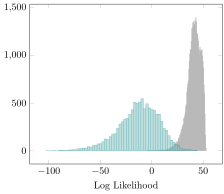

In [92]:
ax = Axis()
push!(ax, Plots.Histogram(ll_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(ll_out, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Log Likelihood"
ax

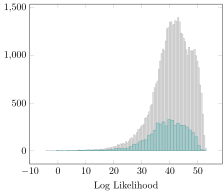

In [93]:
ax = Axis()
push!(ax, Plots.Histogram(ll_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(ll_c, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Log Likelihood"
ax

# Train Decoder

In [94]:
nepoch = 250
lr = 1e-3
batchsize = 128

train_decoder(npn.decoder, z_in, y, nepoch = nepoch, lr = lr, batchsize = batchsize);

l = 0.17838934554837782


┌ Info: Epoch 1
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.1321906303524647


┌ Info: Epoch 2
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.10846285768870097


┌ Info: Epoch 3
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.09850500168431303


┌ Info: Epoch 4
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.09624334587208974


┌ Info: Epoch 5
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0915195072135876


┌ Info: Epoch 6
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08871511909881497


┌ Info: Epoch 7
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08766238007729982


┌ Info: Epoch 8
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08495831355036669


┌ Info: Epoch 9
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08405854893443883


┌ Info: Epoch 10
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08244944235995837


┌ Info: Epoch 11
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08058251998027677


┌ Info: Epoch 12
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.08052206831868505


┌ Info: Epoch 13
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07983853364792652


┌ Info: Epoch 14
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07867356982357634


┌ Info: Epoch 15
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07891720803975855


┌ Info: Epoch 16
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07743039358382132


┌ Info: Epoch 17
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07506469052966608


┌ Info: Epoch 18
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07464595670882385


┌ Info: Epoch 19
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07582550358908044


┌ Info: Epoch 20
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07578212052339098


┌ Info: Epoch 21
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07570659316263459


┌ Info: Epoch 22
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07376715273398583


┌ Info: Epoch 23
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07226980003445999


┌ Info: Epoch 24
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07338505927895096


┌ Info: Epoch 25
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0717139899027337


┌ Info: Epoch 26
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07074007264652377


┌ Info: Epoch 27
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.072352363754343


┌ Info: Epoch 28
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07030261663486045


┌ Info: Epoch 29
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07378005033902409


┌ Info: Epoch 30
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07098210319690092


┌ Info: Epoch 31
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06991624251131723


┌ Info: Epoch 32
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07182433024874253


┌ Info: Epoch 33
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.069265543653814


┌ Info: Epoch 34
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06869190633132195


┌ Info: Epoch 35
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06952384456456619


┌ Info: Epoch 36
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.07063640980556554


┌ Info: Epoch 37
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06879850684462142


┌ Info: Epoch 38
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06858094060933499


┌ Info: Epoch 39
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06844659959927843


┌ Info: Epoch 40
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06915160668900011


┌ Info: Epoch 41
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06715994997894675


┌ Info: Epoch 42
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0681991378101756


┌ Info: Epoch 43
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06704323575094548


┌ Info: Epoch 44
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06907195781428949


┌ Info: Epoch 45
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06869246049597795


┌ Info: Epoch 46
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0675717625998115


┌ Info: Epoch 47
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06753594677926882


┌ Info: Epoch 48
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06633816413573355


┌ Info: Epoch 49
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06933412357624315


┌ Info: Epoch 50
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0661440924326212


┌ Info: Epoch 51
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06526287000924419


┌ Info: Epoch 52
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06672276277168786


┌ Info: Epoch 53
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0651260900645016


┌ Info: Epoch 54
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06581638313065723


┌ Info: Epoch 55
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06437099552146565


┌ Info: Epoch 56
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06522073773178876


┌ Info: Epoch 57
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06455218350764193


┌ Info: Epoch 58
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06441851112787869


┌ Info: Epoch 59
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06509516202864071


┌ Info: Epoch 60
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06400561919083747


┌ Info: Epoch 61
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06388565541773406


┌ Info: Epoch 62
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06652301900962161


┌ Info: Epoch 63
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06241197309178059


┌ Info: Epoch 64
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06427167328932076


┌ Info: Epoch 65
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06283049073412875


┌ Info: Epoch 66
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0647551860982003


┌ Info: Epoch 67
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06364268811460608


┌ Info: Epoch 68
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06410429827125484


┌ Info: Epoch 69
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06288668479873846


┌ Info: Epoch 70
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0629629939992503


┌ Info: Epoch 71
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0641982412294703


┌ Info: Epoch 72
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06218751815386606


┌ Info: Epoch 73
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06319862970819747


┌ Info: Epoch 74
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06128388919712604


┌ Info: Epoch 75
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06448293670981325


┌ Info: Epoch 76
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06499133740010694


┌ Info: Epoch 77
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06217311693267486


┌ Info: Epoch 78
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06183596646611552


┌ Info: Epoch 79
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.061559739285551716


┌ Info: Epoch 80
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06322019031722013


┌ Info: Epoch 81
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.062052902182467805


┌ Info: Epoch 82
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06267408429629932


┌ Info: Epoch 83
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06073310382699609


┌ Info: Epoch 84
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06202984384811659


┌ Info: Epoch 85
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06212303216371029


┌ Info: Epoch 86
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06806069106842243


┌ Info: Epoch 87
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06229541644715752


┌ Info: Epoch 88
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06183397717178002


┌ Info: Epoch 89
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.060322402096507945


┌ Info: Epoch 90
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.061845710295073554


┌ Info: Epoch 91
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06028524305788777


┌ Info: Epoch 92
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.059987289822940056


┌ Info: Epoch 93
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06233711513819903


┌ Info: Epoch 94
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06044506369315013


┌ Info: Epoch 95
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06171191814868334


┌ Info: Epoch 96
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.060741380676627675


┌ Info: Epoch 97
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06027264722113636


┌ Info: Epoch 98
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05932120833883531


┌ Info: Epoch 99
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05969244497213708


┌ Info: Epoch 100
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06109545883834798


┌ Info: Epoch 101
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05893335269944554


┌ Info: Epoch 102
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.060194034148516644


┌ Info: Epoch 103
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.059534622123068495


┌ Info: Epoch 104
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05953493591305124


┌ Info: Epoch 105
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0594228259507999


┌ Info: Epoch 106
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.061958195630281945


┌ Info: Epoch 107
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.060598271071383915


┌ Info: Epoch 108
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.061476834105925984


┌ Info: Epoch 109
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06008396472179574


┌ Info: Epoch 110
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.060641023264013


┌ Info: Epoch 111
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06376239173685345


┌ Info: Epoch 112
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.058770725869915684


┌ Info: Epoch 113
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06105999114547779


┌ Info: Epoch 114
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0597251388047689


┌ Info: Epoch 115
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05980189510700279


┌ Info: Epoch 116
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06112564545287887


┌ Info: Epoch 117
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05881965670997456


┌ Info: Epoch 118
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06102337278616493


┌ Info: Epoch 119
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05955577325058534


┌ Info: Epoch 120
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05828738487822753


┌ Info: Epoch 121
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.059138920703258824


┌ Info: Epoch 122
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.059039749718196886


┌ Info: Epoch 123
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06020177633484099


┌ Info: Epoch 124
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06118300913115019


┌ Info: Epoch 125
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05969011821331937


┌ Info: Epoch 126
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05906215778193736


┌ Info: Epoch 127
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06022153317719021


┌ Info: Epoch 128
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05855383604991365


┌ Info: Epoch 129
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.059109412617119106


┌ Info: Epoch 130
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05802321724614273


┌ Info: Epoch 131
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05988590558874881


┌ Info: Epoch 132
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05869401738172717


┌ Info: Epoch 133
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05845265407032689


┌ Info: Epoch 134
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05954450323213625


┌ Info: Epoch 135
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05841099513153302


┌ Info: Epoch 136
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05817258637422621


┌ Info: Epoch 137
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0591504820502093


┌ Info: Epoch 138
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05838998836821198


┌ Info: Epoch 139
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05949068631419521


┌ Info: Epoch 140
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05938149025920874


┌ Info: Epoch 141
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05794460294350934


┌ Info: Epoch 142
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0601292834912166


┌ Info: Epoch 143
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05843417840182801


┌ Info: Epoch 144
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05806257939884638


┌ Info: Epoch 145
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.06324123153183915


┌ Info: Epoch 146
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.058438548218914


┌ Info: Epoch 147
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05963546810802466


┌ Info: Epoch 148
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.057704363351948826


┌ Info: Epoch 149
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05805252253086467


┌ Info: Epoch 150
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05736636780518709


┌ Info: Epoch 151
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05839107834839548


┌ Info: Epoch 152
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05847694692360758


┌ Info: Epoch 153
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.057154039883009516


┌ Info: Epoch 154
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05849656285365618


┌ Info: Epoch 155
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05741322988257918


┌ Info: Epoch 156
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05666817360102418


┌ Info: Epoch 157
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05892746103492873


┌ Info: Epoch 158
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05637535753542819


┌ Info: Epoch 159
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.057637460367720564


┌ Info: Epoch 160
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05950249742798892


┌ Info: Epoch 161
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05648959691666435


┌ Info: Epoch 162
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05718689046527282


┌ Info: Epoch 163
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05636595013377807


┌ Info: Epoch 164
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05634653727202665


┌ Info: Epoch 165
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05664212553123802


┌ Info: Epoch 166
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05784612839302299


┌ Info: Epoch 167
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056276258655510586


┌ Info: Epoch 168
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.055729793252745644


┌ Info: Epoch 169
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05625446801372279


┌ Info: Epoch 170
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.055612266939959625


┌ Info: Epoch 171
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.057409149867908786


┌ Info: Epoch 172
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05492600581172852


┌ Info: Epoch 173
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056535572854400924


┌ Info: Epoch 174
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05529068453626078


┌ Info: Epoch 175
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05829667325975569


┌ Info: Epoch 176
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05708127501718989


┌ Info: Epoch 177
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056328874664942664


┌ Info: Epoch 178
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.058824610297396905


┌ Info: Epoch 179
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056410466699789386


┌ Info: Epoch 180
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05695846399044531


┌ Info: Epoch 181
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056326153644329795


┌ Info: Epoch 182
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.055919397209869826


┌ Info: Epoch 183
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056736065674109784


┌ Info: Epoch 184
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05589089834616261


┌ Info: Epoch 185
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.054702123959129


┌ Info: Epoch 186
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05534830689967484


┌ Info: Epoch 187
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0574035446395489


┌ Info: Epoch 188
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.058606134555969996


┌ Info: Epoch 189
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053680400314308714


┌ Info: Epoch 190
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0554834289884127


┌ Info: Epoch 191
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.054833815282168526


┌ Info: Epoch 192
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05534022332740182


┌ Info: Epoch 193
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05512551797643744


┌ Info: Epoch 194
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05471598338470993


┌ Info: Epoch 195
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05505494093349531


┌ Info: Epoch 196
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05573780952078293


┌ Info: Epoch 197
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053964996421330756


┌ Info: Epoch 198
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05465450183245866


┌ Info: Epoch 199
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05851541749604874


┌ Info: Epoch 200
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056995210475776166


┌ Info: Epoch 201
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05344183944859924


┌ Info: Epoch 202
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.056975836635074675


┌ Info: Epoch 203
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0543586414843401


┌ Info: Epoch 204
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0537638081329312


┌ Info: Epoch 205
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05391985976140038


┌ Info: Epoch 206
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.054892193994896296


┌ Info: Epoch 207
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.0530362550144719


┌ Info: Epoch 208
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053486168798588196


┌ Info: Epoch 209
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.054985330959937344


┌ Info: Epoch 210
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05384502894290286


┌ Info: Epoch 211
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05380341328069215


┌ Info: Epoch 212
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.052655327446233954


┌ Info: Epoch 213
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05485488566696807


┌ Info: Epoch 214
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05331259324446254


┌ Info: Epoch 215
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05680810359091146


┌ Info: Epoch 216
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05457041517292955


┌ Info: Epoch 217
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05303438896137953


┌ Info: Epoch 218
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05360789754142986


┌ Info: Epoch 219
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053620929415055134


┌ Info: Epoch 220
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05464929427227405


┌ Info: Epoch 221
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05385874225862442


┌ Info: Epoch 222
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05874132576786876


┌ Info: Epoch 223
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.052113704797983294


┌ Info: Epoch 224
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05385765903354611


┌ Info: Epoch 225
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05382489700344746


┌ Info: Epoch 226
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05440930399944356


┌ Info: Epoch 227
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05519058971472016


┌ Info: Epoch 228
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053308645767654754


┌ Info: Epoch 229
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05225046218961985


┌ Info: Epoch 230
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05290332743518574


┌ Info: Epoch 231
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05345340915123034


┌ Info: Epoch 232
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05333310078626721


┌ Info: Epoch 233
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05233821677440887


┌ Info: Epoch 234
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.052341289134703026


┌ Info: Epoch 235
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05362913342392573


┌ Info: Epoch 236
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05504960025511871


┌ Info: Epoch 237
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05224401936526541


┌ Info: Epoch 238
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.054591346845499815


┌ Info: Epoch 239
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05361216380350071


┌ Info: Epoch 240
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05202336991845883


┌ Info: Epoch 241
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05291215891935778


┌ Info: Epoch 242
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05309797096103469


┌ Info: Epoch 243
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.052501677786237426


┌ Info: Epoch 244
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05308223461648416


┌ Info: Epoch 245
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05410418173314037


┌ Info: Epoch 246
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05275983950589834


┌ Info: Epoch 247
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.053817851733744114


┌ Info: Epoch 248
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05236420789277332


┌ Info: Epoch 249
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = 0.05336425780932802


┌ Info: Epoch 250
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


# Run Bayesian Loss

In [12]:
npn.entropy_reg = 1e-3

nepoch = 150
lr = 1e-4
batchsize = 128

npn = train_npn(npn, X, y, nepoch, lr, batchsize, simple = true);

┌ Info: Epoch 1
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6285964857667263
1 / n: 0.1596382865983606
entropy reg term: 0.0026646541515649093
l = 32267.239176920353


┌ Info: Epoch 2
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6079868851427181
1 / n: 0.0855371862148969
entropy reg term: 0.003487663351948195
l = 31174.50924228539


┌ Info: Epoch 3
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6060439026820335
1 / n: 0.04827166502772686
entropy reg term: 0.003994208385913265
l = 31056.207944507893


mse: 0.6059829746737049
1 / n: 0.035484356354277866
entropy reg term: 0.004303058228053413
l = 31046.699459559844


┌ Info: Epoch 4
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6086383177379672
1 / n: 0.025642468738079502
entropy reg term: 0.004683760149059856
l = 31177.808897374132


┌ Info: Epoch 5
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 6
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6063142054424181
1 / n: 0.02053481232173766
entropy reg term: 0.00479461429897083
l = 31056.255985081614


mse: 0.6068083351699447
1 / n: 0.015670842181378108
entropy reg term: 0.005076615627180224
l = 31079.209459099162


┌ Info: Epoch 7
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6075062819987277
1 / n: 0.014284971131597735
entropy reg term: 0.0051802496338027755
l = 31114.287831366753


┌ Info: Epoch 8
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 9
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6112383380953799
1 / n: 0.010733431581361263
entropy reg term: 0.005440103714214629
l = 31303.68376055478


mse: 0.6059116232170354
1 / n: 0.010028192501158833
entropy reg term: 0.0054399429511630204
l = 31030.594794063803


┌ Info: Epoch 10
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6078396948546461
1 / n: 0.008209852493897189
entropy reg term: 0.005629072645229621
l = 31128.477906229113


┌ Info: Epoch 11
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 12
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6060957847860595
1 / n: 0.006803302611728649
entropy reg term: 0.005805318057499319
l = 31038.559794828896


┌ Info: Epoch 13
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6050303668278649
1 / n: 0.006530723544896087
entropy reg term: 0.005808867006591077
l = 30983.872651949037


┌ Info: Epoch 14
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6051482745556764
1 / n: 0.005068261190453775
entropy reg term: 0.006067523112107016
l = 30989.29317881356


mse: 0.6028354195114537
1 / n: 0.0046462557812107005
entropy reg term: 0.006092694672354033
l = 30870.671821618653


┌ Info: Epoch 15
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 16
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6024712245329856
1 / n: 0.004597638262740435
entropy reg term: 0.006093779535829177
l = 30852.000702001733


┌ Info: Epoch 17
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.6019229154655948
1 / n: 0.004004192480936943
entropy reg term: 0.0062296117369992875
l = 30823.692979598043


mse: 0.5987968762217694
1 / n: 0.003668109171215214
entropy reg term: 0.006289652766876816
l = 30663.49843666689


┌ Info: Epoch 18
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.5936499171917788
1 / n: 0.003961008416205095
entropy reg term: 0.006222927491152477
l = 30400.089935403645


┌ Info: Epoch 19
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.5875330440920116
1 / n: 0.0033395660776779686
entropy reg term: 0.006378354913325486
l = 30086.667433058374


┌ Info: Epoch 20
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.5823432041000781
1 / n: 0.003746452884668711
entropy reg term: 0.006354479892706777
l = 29821.14372750602


┌ Info: Epoch 21
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 22
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.5621682567196066
1 / n: 0.003501562919552008
entropy reg term: 0.006385487447418869
l = 28788.076913831745


mse: 0.544449082360652
1 / n: 0.0035986778650158296
entropy reg term: 0.006426446246863731
l = 27880.92588041068


┌ Info: Epoch 23
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.45634171909250515
1 / n: 0.005305201237502042
entropy reg term: 0.00639515034240297
l = 23370.68659754518


┌ Info: Epoch 24
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 25
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.38705286762060315
1 / n: 0.004474894913820813
entropy reg term: 0.006607806448617353
l = 19822.78116527245


mse: 0.3420816625705584
1 / n: 0.003653417374435905
entropy reg term: 0.006661923340396102
l = 17519.862578058586


┌ Info: Epoch 26
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.29218932823933935
1 / n: 0.0035995609574662572
entropy reg term: 0.006613645266885611
l = 14965.322767441045


┌ Info: Epoch 27
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 28
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.2501485271634573
1 / n: 0.0031769494226259027
entropy reg term: 0.006659283163361248
l = 12812.640741853043


mse: 0.214343805493859
1 / n: 0.0031145840170326558
entropy reg term: 0.006657343371117096
l = 10979.406068108316


┌ Info: Epoch 29
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.18155244415912206
1 / n: 0.0027456214862732085
entropy reg term: 0.006726100679312027
l = 9300.33466269583


┌ Info: Epoch 30
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.15713599668716757
1 / n: 0.0033067658031777844
entropy reg term: 0.0067308739473047425
l = 8050.502301935227


┌ Info: Epoch 31
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 32
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.13863723647145457
1 / n: 0.003143780966700867
entropy reg term: 0.00680544426805776
l = 7103.32051065867


mse: 0.11988668990820384
1 / n: 0.00238476314861188
entropy reg term: 0.0069770628810813294
l = 6142.9917782272405


┌ Info: Epoch 33
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 34
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.1036177429761573
1 / n: 0.0021827403194788525
entropy reg term: 0.007067542408479704
l = 5309.96458513597


mse: 0.09495383423974137
1 / n: 0.0023299786079229957
entropy reg term: 0.007064540710801442
l = 4866.446306965945


┌ Info: Epoch 35
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 36
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.08419096043302227
1 / n: 0.0022766667385120476
entropy reg term: 0.007074277604461791
l = 4315.364857674342


mse: 0.07462285723523195
1 / n: 0.0016924141058049012
entropy reg term: 0.007207129178685701
l = 3825.246856605535


┌ Info: Epoch 37
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.06345603407257867
1 / n: 0.0017039043795214232
entropy reg term: 0.007188969478016183
l = 3253.5020959310878


┌ Info: Epoch 38
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.055281595654337316
1 / n: 0.001676489896265373
entropy reg term: 0.007191909610488299
l = 2834.9583180495283


┌ Info: Epoch 39
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 40
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.055766811041352476
1 / n: 0.0019212088861909166
entropy reg term: 0.007113912391541823
l = 2859.886707411446


mse: 0.04965556536223531
1 / n: 0.001723373637961341
entropy reg term: 0.007135326834382206
l = 2546.9006011882875


┌ Info: Epoch 41
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.04564122929285612
1 / n: 0.0017516058494493406
entropy reg term: 0.007087068498211493
l = 2341.3563410602364


┌ Info: Epoch 42
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 43
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.043203041641580286
1 / n: 0.0018108364327263998
entropy reg term: 0.0069672866126223995
l = 2216.49013104813


┌ Info: Epoch 44
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.04359195091502609
1 / n: 0.0016429770977081572
entropy reg term: 0.0069980876241744665
l = 2236.3321119869397


┌ Info: Epoch 45
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.04030099534580045
1 / n: 0.0018177827649501598
entropy reg term: 0.006870456102778542
l = 2067.8593400052596


mse: 0.03889298147639406
1 / n: 0.0019001621806082768
entropy reg term: 0.006813637654796849
l = 1995.7821171071043


┌ Info: Epoch 46
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.03549885434355535
1 / n: 0.0019410890606407966
entropy reg term: 0.0067782445223707735
l = 1822.0056411845358


┌ Info: Epoch 47
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 48
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.03518562361446725
1 / n: 0.0020728473716909493
entropy reg term: 0.006715051759640654
l = 1806.0033334159655


mse: 0.03581666126797566
1 / n: 0.002001627054108988
entropy reg term: 0.006717579734097759
l = 1838.2772907959156


┌ Info: Epoch 49
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.03477242186213575
1 / n: 0.002110109647217001
entropy reg term: 0.006647549842971191
l = 1784.8319210003265


┌ Info: Epoch 50
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.032761943931167097
1 / n: 0.0020675356317721243
entropy reg term: 0.0066525787509004305
l = 

┌ Info: Epoch 51
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


1681.876227839684


mse: 0.030850592813846632
1 / n: 0.002465386090645296
entropy reg term: 0.006532634852539437
l = 1584.157338791858


┌ Info: Epoch 52
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 53
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.030944535450269605
1 / n: 0.0021614856521138207
entropy reg term: 0.006617871710209597
l = 1588.855246023313


mse: 0.03284221260639044
1 / n: 0.001980781878927593
entropy reg term: 0.006665006255515098
l = 1685.9479289720252


┌ Info: Epoch 54
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.030289250894756092
1 / n: 0.002035405620717608
entropy reg term: 0.0066283120084089375
l = 1555.2454692376245


┌ Info: Epoch 55
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02774219425348836
1 / n: 0.002298083996267681
entropy reg term: 0.0065506706511897096
l = 1424.9309081581023


┌ Info: Epoch 56
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.03009581300781095
1 / n: 0.002019793049613817
entropy reg term: 0.006603273784179463
l = 1545.3206362188225


┌ Info: Epoch 57
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.026909849912444866
1 / n: 0.0022483672037042074
entropy reg term: 0.006536254567216291
l = 1382.2820418638878


┌ Info: Epoch 58
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 59
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.026054024350003382
1 / n: 0.002121490441406266
entropy reg term: 0.006606963044471717
l = 1338.4350149049426


mse: 0.026870155861895693
1 / n: 0.0018840874089010547
entropy reg term: 0.006665913308838511
l = 1380.1295804965418


┌ Info: Epoch 60
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02931381770863807
1 / n: 0.0020031918211377685
entropy reg term: 0.006597281745194008
l = 1505.2709091482309


┌ Info: Epoch 61
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.025413657379596544
1 / n: 0.0020172641231759126
entropy reg term: 0.0065799694191052485
l = 1305.581041408991


┌ Info: Epoch 62
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 63
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02704815937214602
1 / n: 0.001965826851439434
entropy reg term: 0.006602982672219525
l = 1389.2529903299896


┌ Info: Epoch 64
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.026428877493303873
1 / n: 0.001820811105494428
entropy reg term: 0.0066877472143018046
l = 1357.514909516894


mse: 0.024026281502658203
1 / n: 0.0019230869315794029
entropy reg term: 0.006643331353067936
l = 1234.531619097839


┌ Info: Epoch 65
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 66
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.023508374729849003
1 / n: 0.0019494042520168593
entropy reg term: 0.006601440343642316
l = 1208.0068186012463


mse: 0.024087709324407156
1 / n: 0.001873032851893368
entropy reg term: 0.006633500074160213
l = 1237.646062267786


┌ Info: Epoch 67
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 68
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.023772341121315283
1 / n: 0.001832729947038514
entropy reg term: 0.006677564326657842
l = 1221.501136079475


mse: 0.022780908983325146
1 / n: 0.0017966280407043748
entropy reg term: 0.0066736732128918515
l = 1170.7193341880886


┌ Info: Epoch 69
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.023029563497382888
1 / n: 0.0019513870803123242
entropy reg term: 0.00663182381891256
l = 1183.508255046407


┌ Info: Epoch 70
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02149695510804802
1 / n: 0.0018939637109211811
entropy reg term: 0.00661842686986249
l = 1105.0024455094199


┌ Info: Epoch 71
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.019815285230965433
1 / n: 0.0019066318844596197
entropy reg term: 0.006642185635546991
l = 1018.9195983956736


┌ Info: Epoch 72
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02225993348484035
1 / n: 0.001743907537733802
entropy reg term: 0.006704549063445101
l = 1144.03420420363


┌ Info: Epoch 73
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 74
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01968987218378109
1 / n: 0.00200420353018444
entropy reg term: 0.0065766382827772705
l = 1012.5148468178278


┌ Info: Epoch 75
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.021862135283401495
1 / n: 0.0018594770787322148
entropy reg term: 0.0066247206875124755
l = 1123.6852357664739


mse: 0.0199669247275084
1 / n: 0.0017330919221318643
entropy reg term: 0.006681777827837132
l = 1026.6149593604143


┌ Info: Epoch 76
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.022892505317284588
1 / n: 0.001799093975369117
entropy reg term: 0.006645134871342239
l = 1176.4197174144874


┌ Info: Epoch 77
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02032185368800352
1 / n: 0.0018527950164534276
entropy reg term: 0.006611077908425958
l = 1044.8124117633183


┌ Info: Epoch 78
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.018971792506450716
1 / n: 0.001862847121690301
entropy reg term: 0.006603574220338366
l = 975.6905840573954


┌ Info: Epoch 79
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 80
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.018277034909831666
1 / n: 0.0017763542912061993
entropy reg term: 0.006672860000190306
l = 940.1101851005765


mse: 0.018657804321838785
1 / n: 0.001889371520738476
entropy reg term: 0.006597285030144253
l = 959.6247494321976


┌ Info: Epoch 81
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.02016781145108893
1 / n: 0.0017048539274820693
entropy reg term: 0.0066918422670380895
l = 1036.8910547473474


┌ Info: Epoch 82
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 83
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.018558465889603935
1 / n: 0.0018466646991389937
entropy reg term: 0.006615355065177208
l = 954.5260076670514


mse: 0.01679890462491495
1 / n: 0.0018304522872191122
entropy reg term: 0.006624382548002402
l = 864.4327922312788


┌ Info: Epoch 84
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 85
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01698985212405652
1 / n: 0.001954525620403526
entropy reg term: 0.006599085401497558
l = 874.2598775949073


mse: 0.016609204366524508
1 / n: 0.0018826735634069635
entropy reg term: 0.006607049940485741
l = 854.7380020000483


┌ Info: Epoch 86
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.017554078124330994
1 / n: 0.0018785665797862886
entropy reg term: 0.006599619533057219
l = 903.1096312555223


┌ Info: Epoch 87
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.017164354228340045
1 / n: 0.0016750532396863766
entropy reg term: 0.006699147959684056
l = 883.1025275050879


┌ Info: Epoch 88
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.016277478061357487
1 / n: 0.0018464855792154496
entropy reg term: 0.006602000291181685
l = 837.7325015071467


┌ Info: Epoch 89
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 90
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01658881644977708
1 / n: 0.001928087056901321
entropy reg term: 0.006569345214958487
l = 853.6980875517786


mse: 0.016025611919194282
1 / n: 0.0018551556737485932
entropy reg term: 0.006596943024521247
l = 824.8388047962612


┌ Info: Epoch 91
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.018936021164164738
1 / n: 0.001755554835822712
entropy reg term: 0.006618225433582955
l = 973.8116591031702


┌ Info: Epoch 92
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01585313237651139
1 / n: 0.002013730607744028
entropy reg term: 0.006548245079195629
l = 816.0641092290961


┌ Info: Epoch 93
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.015682130972227582
1 / n: 0.0019781120409689767
entropy reg term: 0.006539142283316642
l = 807.2859399920865


┌ Info: Epoch 94
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 95
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014898271908514671
1 / n: 0.0018323844904490731
entropy reg term: 0.006622007496677661
l = 767.12017041336


mse: 0.014830111981328095
1 / n: 0.00197298315131724
entropy reg term: 0.006553698580675662
l = 763.6673944907786


┌ Info: Epoch 96
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014773362648356084
1 / n: 0.0019352904151861334
entropy reg term: 0.006554876052826976
l = 760.743132827454


┌ Info: Epoch 97
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014341965381721642
1 / n: 0.001799949026474616
entropy reg term: 0.006620233306206534
l = 738.6197608984809


┌ Info: Epoch 98
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 99
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.015146693505934441
1 / n: 0.0017791887773462487
entropy reg term: 0.0066201886972139645
l = 779.8111887708183


┌ Info: Epoch 100
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014352323062525691
1 / n: 0.0018425626005251652
entropy reg term: 0.006584125714223051
l = 739.1534052184666


mse: 0.014428360285121228
1 / n: 0.0017790409020786943
entropy reg term: 0.006624106239442735
l = 743.0344579346659


┌ Info: Epoch 101
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014033195861562769
1 / n: 0.0017851162964473283
entropy reg term: 0.006621142533191126
l = 722.8036326327887


┌ Info: Epoch 102
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014343069461814201
1 / n: 0.0016455009785105673
entropy reg term: 0.006699957869253818
l = 

┌ Info: Epoch 103
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


738.6380313749426


mse: 0.015169634873344034
1 / n: 0.0016978737498453168
entropy reg term: 0.006643126214392711
l = 780.9558974969043


┌ Info: Epoch 104
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 105
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01446066801049313
1 / n: 0.0017513895741654894
entropy reg term: 0.006624850041281403
l = 744.6748368203571


┌ Info: Epoch 106
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013673143236029504
1 / n: 0.0018152867281855797
entropy reg term: 0.006608159051867778
l = 704.377737924098


mse: 0.013997007469216427
1 / n: 0.0016925628470033437
entropy reg term: 0.006661102069141255
l = 720.9238588609471


┌ Info: Epoch 107
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013719141773453881
1 / n: 0.001780867468376338
entropy reg term: 0.006610092874627669
l = 706.7162304964568


┌ Info: Epoch 108
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014496956302135447
1 / n: 0.0016883900550440825
entropy reg term: 0.006653968981930498
l = 746.5154504962655


┌ Info: Epoch 109
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013635561373651578
1 / n: 0.0018228206027721507
entropy reg term: 0.006599487082527426
l = 702.452963865834


┌ Info: Epoch 110
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013813655077893772
1 / n: 0.0017922519182096833
entropy reg term: 0.0065933319754870635
l = 711.5525589417338


┌ Info: Epoch 111
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013982625276943385
1 / n: 0.001803786990020129
entropy reg term: 0.006584544666297173
l = 720.2052399875358


┌ Info: Epoch 112
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 113
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013093814024155275
1 / n: 0.0016847183873421687
entropy reg term: 0.0066599647881382265
l = 674.6757558225962


mse: 0.013430439415103563
1 / n: 0.0018984646159988447
entropy reg term: 0.0065544435885966
l = 691.9663870540555


┌ Info: Epoch 114
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 115
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.014079847848103408
1 / n: 0.001630983944447869
entropy reg term: 0.006676548386920078
l = 725.1416663765548


┌ Info: Epoch 116
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012425640574939778
1 / n: 0.0017585361160875205
entropy reg term: 0.006618390533502276
l = 640.4817838815067


┌ Info: Epoch 117
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012542367172045465
1 / n: 0.0016997811422539845
entropy reg term: 0.006631120315207703
l = 646.4346207549481


┌ Info: Epoch 118
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011986824213536244
1 / n: 0.0018972426031049184
entropy reg term: 0.0065669232024328245
l = 618.059052625491


┌ Info: Epoch 119
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012587863236029038
1 / n: 0.0017644636765644962
entropy reg term: 0.006601524982335307
l = 648.7819838780435


┌ Info: Epoch 120
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011990202265300525
1 / n: 0.0018060504143864223
entropy reg term: 0.006581024167973969
l = 618.1925381695555


mse: 0.012108522507266132
1 / n: 0.0018285601893546434
entropy reg term: 0.006576940729631578
l = 624.259968842547


┌ Info: Epoch 121
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011723302329287392
1 / n: 0.0018368193793869012
entropy reg term: 0.006579615956037142
l = 604.5422941512516


┌ Info: Epoch 122
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 123
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.013149762981141554
1 / n: 0.0017950594639061267
entropy reg term: 0.006588714340044996
l = 677.5603568220705


┌ Info: Epoch 124
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012126719544070226
1 / n: 0.0018707912639742584
entropy reg term: 0.006546462887840771
l = 625.197674782125


mse: 0.011486633040386671
1 / n: 0.0019976712259947528
entropy reg term: 0.006499260632126505
l = 592.4660407791557


┌ Info: Epoch 125
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011669537485429645
1 / n: 0.0018260211562430326
entropy reg term: 0.006581767468016495
l = 601.7851070296189


┌ Info: Epoch 126
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011256205895883137
1 / n: 0.001733845036937416
entropy reg term: 0.006615553063550261
l = 580.5926336966663


┌ Info: Epoch 127
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 128
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012487728631561846
1 / n: 0.0017265410046514412
entropy reg term: 0.006614739419520831
l = 643.6424415131427


mse: 0.011826385332117098
1 / n: 0.001630158196029749
entropy reg term: 0.006662930061998049
l = 609.7569901925057


┌ Info: Epoch 129
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011336690377372744
1 / n: 0.0016369782723236275
entropy reg term: 0.006673286018282129
l = 584.6934026382746


┌ Info: Epoch 130
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011652196371302957
1 / n: 0.0017104924268218948
entropy reg term: 0.006616495400867318
l = 600.8558719784883


┌ Info: Epoch 131
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011621703275985636
1 / n: 0.0016781139848484504
entropy reg term: 0.006624931486983617
l = 

┌ Info: Epoch 132
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


599.2823670120428


┌ Info: Epoch 133
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.011255148610665502
1 / n: 0.001699212532306958
entropy reg term: 0.006627801515244902
l = 580.5270400584204


┌ Info: Epoch 134
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.012117199827016785
1 / n: 0.0015546885111904411
entropy reg term: 0.006689213466789443
l = 624.6215089559852


mse: 0.011442486214751588
1 / n: 0.0017139744461899266
entropy reg term: 0.006611819397862514
l = 590.118100643436


┌ Info: Epoch 135
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010973334345190317
1 / n: 0.0016311168403397396
entropy reg term: 0.006649340141067461
l = 566.0743124482248


┌ Info: Epoch 136
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 137
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01091380596898501
1 / n: 0.0016985379915967634
entropy reg term: 0.006633289988899762
l = 563.0527615380468


┌ Info: Epoch 138
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010366362639274106
1 / n: 0.0017164978110956876
entropy reg term: 0.006608730017441826
l = 535.0202837790456


┌ Info: Epoch 139
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010980955443160077
1 / n: 0.0019572309434569748
entropy reg term: 0.0065067914440220505
l = 566.5584981521854


┌ Info: Epoch 140
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010547157016207082
1 / n: 0.0017870448986064733
entropy reg term: 0.006591527278815843
l = 544.304268184643


┌ Info: Epoch 141
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010811035959164206
1 / n: 0.0017442440552267347
entropy reg term: 0.0065985086746476835
l = 557.7965305069031


mse: 0.010509800612086348
1 / n: 0.0017746647194172046
entropy reg term: 0.006571155912546465
l = 542.3748515023866


┌ Info: Epoch 142
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010584899023563266
1 / n: 0.0016016098678922916
entropy reg term: 0.006675436174912253
l = 546.1846775803551


┌ Info: Epoch 143
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.009910764801843918
1 / n: 0.001848766662965783
entropy reg term: 0.0065498221271617215
l = 511.7312353149541


┌ Info: Epoch 144
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


┌ Info: Epoch 145
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010482050232711539
1 / n: 0.0016001207862120597
entropy reg term: 0.006662874835931838
l = 540.9116256733686


mse: 0.010274037290122303
1 / n: 0.0017842028829354911
entropy reg term: 0.006575225011679906
l = 530.3107363363049


┌ Info: Epoch 146
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.009985601264465816
1 / n: 0.0017880826871479103
entropy reg term: 0.0065744039955060755
l = 515.5443779221687


┌ Info: Epoch 147
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01029151573419609
1 / n: 0.0016045436015937186
entropy reg term: 0.006659274991857873
l = 531.156680710687


┌ Info: Epoch 148
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.010156022637296069
1 / n: 0.0016361984582897446
entropy reg term: 0.006641563057970725
l = 524.2265729258842


┌ Info: Epoch 149
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


mse: 0.01066926744485983
1 / n: 0.001559749232805612
entropy reg term: 0.006679864524156054
l = 550.4851754203876


┌ Info: Epoch 150
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


# Post-train Flow

In [231]:
z_in = npn.encoder(X)

nepoch = 50
lr = 1e-4
batchsize = 128

train_flow(npn.flow, z_in, y, nepoch, lr, batchsize);

┌ Info: Epoch 1
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -2.490561897710326
l = -14.753392687011024


┌ Info: Epoch 2
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 3
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -25.73950888768488
l = -30.23802943511945


┌ Info: Epoch 4
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 5
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -30.727399285787996
l = -30.781866632966857


┌ Info: Epoch 6
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -30.811737179479852


┌ Info: Epoch 7
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -30.844291923127575


┌ Info: Epoch 8
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 9
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -30.883480459571103
l = -30.91396505932198


┌ Info: Epoch 10
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -30.956768891295134


┌ Info: Epoch 11
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.00300588162241


┌ Info: Epoch 12
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.039260695203424


┌ Info: Epoch 13
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.092427491390655


┌ Info: Epoch 14
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 15
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.1381904967925
l = -31.178430088887872


┌ Info: Epoch 16
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 17
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.232000697891785
l = -31.28129185651334


┌ Info: Epoch 18
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.333506750004968


┌ Info: Epoch 19
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.382416248907127


┌ Info: Epoch 20
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.43234080744393


┌ Info: Epoch 21
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.489792092993557


┌ Info: Epoch 22
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.540294971853985


┌ Info: Epoch 23
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 24
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.59794904844576
l = -31.64179046556625


┌ Info: Epoch 25
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.698473544453492


┌ Info: Epoch 26
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 27
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.744549100269925
l = -31.790764680914542


┌ Info: Epoch 28
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.850973767599378


┌ Info: Epoch 29
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.898134264401595


┌ Info: Epoch 30
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.946908752386776


┌ Info: Epoch 31
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -31.993872449964986


┌ Info: Epoch 32
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 33
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.03471829498241
l = -32.07344337485992


┌ Info: Epoch 34
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.12157092082048


┌ Info: Epoch 35
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.15173029965884


┌ Info: Epoch 36
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.199220712415695


┌ Info: Epoch 37
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.229407144087865


┌ Info: Epoch 38
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.27222381877879


┌ Info: Epoch 39
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.30539619033399


┌ Info: Epoch 40
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.33338478824575


┌ Info: Epoch 41
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.362893364502604


┌ Info: Epoch 42
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.393842881907254


┌ Info: Epoch 43
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.42346856470855


┌ Info: Epoch 44
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.45053461396548


┌ Info: Epoch 45
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.47199788234083


┌ Info: Epoch 46
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.50362689419853


┌ Info: Epoch 47
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136
┌ Info: Epoch 48
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.527813446613465


┌ Info: Epoch 49
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


l = -32.54914497361716
l = -32.56814565101996


┌ Info: Epoch 50
└ @ Main /home/smkatz/.julia/packages/Flux/YO4zY/src/optimise/train.jl:136


# Analyze Results

In [13]:
ind = 10001 #1042
println(y[:, ind])
println(npn.decoder(npn.encoder(X[:, ind])))

[0.2696518898010254, -0.20502893129984537]
Float32

[0.2702745

, -0.20933789]


0.19999999999999998
4.497402876970928e-6
0.00021619590641903


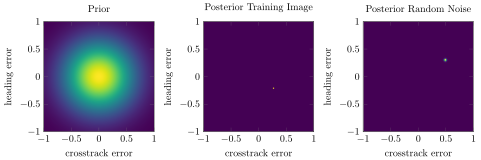

In [21]:
Random.seed!(16)
ax = plot_results(npn, X[:, ind], n_prior = 0.05, simple = true, ymin = -1.0, ymax = 1.0)

In [127]:
#PGFPlots.save("../figs/posterior_example.pdf", ax, include_preamble=false);

In [22]:
using BSON
using BSON: @save 
@save "../networks/npnfull_h16_a01_Nformula_reg1e3_nopretrain.bson" npn

In [23]:
y_pred = npn.decoder(npn.encoder(X));

In [24]:
ax1 = Axis(Plots.Scatter(y[1, 1:25:end] .* 10, y_pred[1, 1:25:end] .* 10, style = "mark size = {0.5pt}"))
push!(ax1, Plots.Linear([-11.0, 11.0], [-11.0, 11.0], style = "black, dashed", mark = "none"))
ax1.xlabel = "True Crosstrack Error"
ax1.ylabel = "Predicted Crosstrack Error"
ax1.xmin = -11.0
ax1.xmax = 11.0
ax1.ymin = -11.0
ax1.ymax = 11.0

ax2 = Axis(Plots.Scatter(y[2, 1:25:end] .* 30, y_pred[2, 1:25:end] .* 30, style = "mark size = {0.5pt}"))
push!(ax2, Plots.Linear([-30.0, 30.0], [-30.0, 30.0], style = "black, dashed", mark = "none"))
ax2.xlabel = "True Heading Error"
ax2.ylabel = "Predicted Heading Error"
ax2.xmin = -30.0
ax2.xmax = 30.0
ax2.ymin = -30.0
ax2.ymax = 30.0

g = GroupPlot(2, 1, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)

#PGFPlots.save("../figs/predictions.pdf", g, include_preamble = false)
g

In [25]:
z_in = npn.encoder(X)
z_out = npn.encoder(Xrand)
z_c = npn.encoder(Xc)
z_a = npn.encoder(Xa)

ll_in = logpdf(npn.flow, z_in)
ll_out = logpdf(npn.flow, z_out)
ll_c = logpdf(npn.flow, z_c)
ll_a = logpdf(npn.flow, z_a);

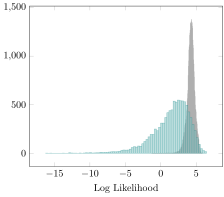

In [26]:
ax = Axis()
push!(ax, Plots.Histogram(ll_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(ll_out, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Log Likelihood"
ax

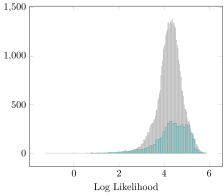

In [27]:
ax = Axis()
push!(ax, Plots.Histogram(ll_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(ll_c, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Log Likelihood"
ax

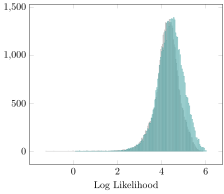

In [28]:
ax = Axis()
push!(ax, Plots.Histogram(ll_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(ll_a, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Log Likelihood"
ax

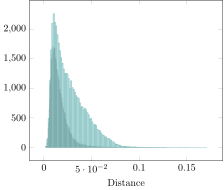

In [167]:
dists_in, dists_out = get_latent_distances(npn.encoder, X, Xa)
ax = Axis()
push!(ax, Plots.Histogram(dists_in, style="gray, fill=gray!50, opacity = 0.5"))
push!(ax, Plots.Histogram(dists_out, style="teal, fill=teal!50, opacity = 0.5"))
ax.xlabel = "Distance"
ax

In [29]:
function get_entropies(npn, X)
    z = npn.encoder(X)
    lls = logpdf(npn.flow, z)
    pzs = exp.(lls)
    ns = npn.Nₕ * pzs
    σ₀²s = npn.σ² ./ ns
    entropies = 0.5 * log.(2π * σ₀²s)
end

get_entropies (generic function with 1 method)

In [244]:
using PDMats

In [246]:
npn = BSON.load("../networks/npnfull_h16_a01_Nformula_reg1e2_morning.bson")[:npn];

In [30]:
ent_in = get_entropies(npn, X)
ent_out = get_entropies(npn, Xrand)
ent_c = get_entropies(npn, Xc);

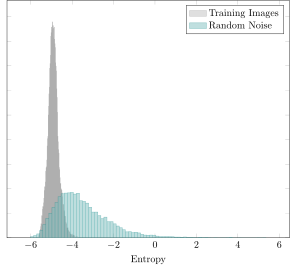

In [37]:
ax = Axis(style = "yticklabels = {,,}")
push!(ax, Plots.Histogram(ent_in, style = "gray, fill=gray!50, opacity = 0.5, area legend", density = true))
push!(ax, Plots.Histogram(ent_out, style = "teal, fill=teal!50, opacity = 0.5, area legend", density = true))
push!(ax, Plots.Command("\\legend{Training Images, Random Noise}"))
ax.xlabel = "Entropy"
ax.ymin = 0.0
ax.height = "10cm"
#PGFPlots.save("../figs/random_entropy_baseline.tex", ax, include_preamble = false)
ax

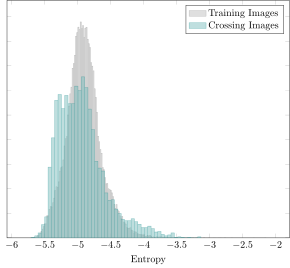

In [38]:
ax = Axis(style = "yticklabels = {,,}")
push!(ax, Plots.Histogram(ent_in, style = "gray, fill=gray!50, opacity = 0.5, area legend", density = true))
push!(ax, Plots.Histogram(ent_c, style = "teal, fill=teal!50, opacity = 0.5, area legend", density = true))
push!(ax, Plots.Command("\\legend{Training Images, Crossing Images}"))
ax.xlabel = "Entropy"
ax.ymin = 0.0
ax.height = "10cm"
# PGFPlots.save("../figs/crossing_entropy_baseline.tex", ax, include_preamble = false)
ax

In [33]:
using NumericalIntegration

function get_roc(ent_in, ent_out)
    sorted_vals = sort(ent_out, rev=true)

    tps = []
    fps = []
    for val in sorted_vals
        push!(tps, sum(ent_out .≥ val))
        push!(fps, sum(ent_in .≥ val))
    end

    return fps ./ length(ent_in), tps ./ length(ent_out)
end

function get_auroc(in_data, out_data)
    fpr, tpr = get_roc(in_data, out_data)
    return integrate(fpr, tpr)
end

get_auroc (generic function with 1 method)

In [35]:
get_auroc(ent_in, ent_c)

0.43610940472469084

In [76]:
fpr, tpr = get_roc(ent_in, ent_out);

In [79]:
auroc = integrate(fpr, tpr)

0.90908861

In [80]:
fpr, tpr = get_roc(ent_in, ent_c)
auroc = integrate(fpr, tpr)

0.35407275000000005

# OoD Images for Report/Poster

In [171]:
function get_random_imgrid(X)
    total_im = zeros(8 * 4 + 3, 16 * 4 + 3)
    im_inds = randperm(size(X, 2))[1:16]
    ind = 1
    for i = 1:4
        for j = 1:4
            im = reverse(reshape(X[:, im_inds[ind]], 16, 8)', dims = 1)
            starti = (i - 1) * 8 + 1 + (i - 1)
            stopi = starti + 7
            startj = (j - 1) * 16 + 1 + (j - 1)
            stopj = startj + 15
            total_im[starti:stopi, startj:stopj] = im
            ind += 1
        end
    end
    return Axis(Plots.MatrixPlot(total_im, zmin = 0.0, zmax = 1.0, 
        colormap = ColorMaps.GrayMap()), style = "yticklabels={,,}, xticklabels={,,}",
        axisEqualImage = true)
end

get_random_imgrid (generic function with 1 method)

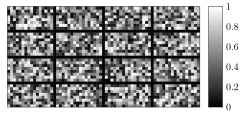

In [237]:
Random.seed!(42)
ax = get_random_imgrid(Xrand)
#PGFPlots.save("random_ims.tex", ax, include_preamble = false)
ax